# PINN solver for Terzaghi's consolidation problem 

Check out our paper for more details: 
**Physics-informed neural network simulation of multiphase poroelasticity using stress-split sequential training**

Find the paper at: [https://arxiv.org/abs/2110.03049](https://arxiv.org/abs/2110.03049)

Try it out on Google Colab: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sciann/sciann-applications/blob/master/SciANN-PoroElasticity/PINN_PoroElasticity_Terzaghi.ipynb)


Cite our work:
```
@article{haghighat2021physics,
  title={Physics-informed neural network simulation of multiphase poroelasticity using stress-split sequential training},
  author={Haghighat, Ehsan and Amini, Danial and Juanes, Ruben},
  journal={arXiv preprint arXiv:2110.03049},
  year={2021}
}
```

In [ ]:
!pip install sciann -q 

     |████████████████████████████████| 173 kB 5.5 MB/s 
     |████████████████████████████████| 561 kB 33.0 MB/s 
     |████████████████████████████████| 460.3 MB 8.0 kB/s 
     |████████████████████████████████| 4.0 MB 40.8 MB/s 
     |████████████████████████████████| 132 kB 70.7 MB/s 
     |████████████████████████████████| 14.8 MB 47.3 MB/s 
     |████████████████████████████████| 462 kB 45.4 MB/s 
     |████████████████████████████████| 1.2 MB 48.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import numpy as np 
import sciann as sn 
from sciann.utils.math import sign, abs, sigmoid, tanh, diff
import os 
import matplotlib.pyplot as plt

---------------------- SCIANN 0.6.5.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.5.3 
Python Version: 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0] 



In [ ]:
#@title Data generator block  
class DataGeneratorXT:
  """ Generates 1D time-dependent collocation grid for training PINNs
  Taken from here: https://github.com/sciann/sciann-applications/tree/master/SciANN-DataGenerator 
  # Arguments:
    X: [X0, X1]
    T: [T0, T1]
    targets: list and type of targets you wish to impose on PINNs. 
        ('domain', 'ic', 'bc-left', 'bc-right', 'all')
    num_sample: total number of collocation points. 
    logT: generate random samples logarithmic in time. 
  # Examples: 
    >> dg = DataGeneratorXT([0., 1.], [0., 1.], ["domain", "ic", "bc-left", "bc-right"], 10000)
    >> input_data, target_data = dg.get_data()
  """
  def __init__(self, 
               X=[0., 1.],
               T=[0., 1.],
               targets=['domain', 'ic', 'bc-left', 'bc-right'], 
               num_sample=10000,
               logT=False):
    'Initialization'
    self.Xdomain = X
    self.Tdomain = T
    self.logT = logT
    self.targets = targets
    self.num_sample = num_sample
    self.input_data = None
    self.target_data = None
    self.set_data()

  def __len__(self):
    return self.input_data[0].shape[0]

  def set_data(self):
    self.input_data, self.target_data = self.generate_data()

  def get_data(self):
    return self.input_data, self.target_data

  def generate_uniform_T_samples(self, num_sample):
    if self.logT is True:
      t_dom = np.random.uniform(np.log1p(self.Tdomain[0]), np.log1p(self.Tdomain[1]), num_sample)
      t_dom = np.exp(t_dom) - 1.
    else:
      t_dom = np.random.uniform(self.Tdomain[0], self.Tdomain[1], num_sample)
    return t_dom

  def generate_data(self):
    # Half of the samples inside the domain.
    num_sample = int(self.num_sample/2)
    
    counter = 0
    # domain points 
    x_dom = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample)
    t_dom = self.generate_uniform_T_samples(num_sample)
    ids_dom = np.arange(x_dom.shape[0])
    counter += ids_dom.size

    # The other half distributed equally between BC and IC.
    num_sample = int(self.num_sample/4)

    # initial conditions
    x_ic = np.random.uniform(self.Xdomain[0], self.Xdomain[1], num_sample)
    t_ic = np.full(num_sample, self.Tdomain[0])
    ids_ic = np.arange(x_ic.shape[0]) + counter 
    counter += ids_ic.size

    # bc points 
    num_sample_per_edge = int(num_sample/2)
    # left bc points 
    x_bc_left = np.full(num_sample_per_edge, self.Xdomain[0])
    t_bc_left = self.generate_uniform_T_samples(num_sample_per_edge)
    ids_bc_left = np.arange(x_bc_left.shape[0]) + counter
    counter += ids_bc_left.size

    # right bc points 
    x_bc_right = np.full(num_sample-num_sample_per_edge, self.Xdomain[1])
    t_bc_right = self.generate_uniform_T_samples(num_sample-num_sample_per_edge)
    ids_bc_right = np.arange(x_bc_right.shape[0]) + counter 
    counter += ids_bc_right.size

    ids_bc = np.concatenate([ids_bc_left, ids_bc_right])
    ids_all = np.concatenate([ids_dom, ids_ic, ids_bc])

    ids = {
        'domain': ids_dom, 
        'bc-left': ids_bc_left, 
        'bc-right': ids_bc_right,
        'ic': ids_ic,
        'bc': ids_bc, 
        'all': ids_all
    }

    assert all([t in ids.keys() for t in self.targets]), \
      'accepted target types: {}'.format(ids.keys())

    input_data = [
        np.concatenate([x_dom, x_ic, x_bc_left, x_bc_right]).reshape(-1,1),
        np.concatenate([t_dom, t_ic, t_bc_left, t_bc_right]).reshape(-1,1),
    ]
    total_sample = input_data[0].shape[0]

    target_data = []
    for i, tp in enumerate(self.targets):
      target_data.append(
          (ids[tp], 'zeros')
      )
      
    return input_data, target_data

  def get_test_grid(self, Nx=200, Nt=200):
    xs = np.linspace(self.Xdomain[0], self.Xdomain[1], Nx)
    if self.logT:
      ts = np.linspace(np.log1p(self.Tdomain[0]), np.log1p(self.Tdomain[1]), Nt)
      ts = np.exp(ts) - 1.0
    else:
      ts = np.linspace(self.Tdomain[0], self.Tdomain[1], Nt)
    return np.meshgrid(xs, ts)

  def plot_sample_batch(self, batch_size=500):
      ids = np.random.choice(len(self), batch_size, replace=False)
      x_data = self.input_data[0][ids,:]
      t_data = self.input_data[1][ids,:]
      plt.scatter(x_data, t_data)
      plt.xlabel('x')
      plt.ylabel('t')
      plt.title('Sample batch = {}'.format(batch_size))
      plt.show()

  def plot_data(self):
      fig = plt.figure()
      for t, (t_idx, t_val) in zip(self.targets, self.target_data):
        x_data = self.input_data[0][t_idx,:]
        t_data = self.input_data[1][t_idx,:]
        plt.scatter(x_data, t_data, label=t, c=next(cycol))
      plt.xlabel('x')
      plt.ylabel('t')
      plt.legend(title="Training Data", bbox_to_anchor=(1.05, 1), loc='upper left')
      fig.tight_layout()
      plt.show()



In [ ]:
s, minute, hr, day = 1., 60., 60.**2, 24*60.**2
g, kg = 1.e-3, 1.
mm, cm, m, km = 1e-3, 1e-2, 1.0, 1e3
Pa, kPa, MPa, GPa = 1.0, 1.e3, 1.e6, 1.e9
micro, milli, centi, kilo, mega = 1e-6, 1e-3, 1e-2, 1e3, 1e6
poise = 0.1*Pa*s
Darcy = 9.869233e-13*m**2

In [ ]:
# ----------------------- Constant Parameters-----------------------#ok

S_overburden = -0.1*MPa
P_ini = 0.*MPa
mu = 6. * milli * poise
k = 1e-12
E = 120.*MPa     
nu = 0.25
b = 1.0
M = 3e11  
Lx = 1*m
Ly = 50*m

Lmbd = E*nu/(1+nu)/(1-2*nu)
Gshr = E/2/(1+nu)
Kdr = E/(3*(1-2*nu))
B = b*M/(Kdr+M*(b**2))
nu_u = (3*nu+b*B*(1-2*nu))/(3-b*B*(1-2*nu))


p_star = (-1)*S_overburden
x_star = Ly
t_star = (b**2/Kdr + 1/M)*mu*(x_star**2)/(k)
nu_star = (1 - 2*nu)/(1 + nu) 
u_star = p_star*x_star/Kdr    
    

In [ ]:
# ----------------------- Neural Network Setup -----------------------
sn.reset_session()
sn.set_random_seed(124)

yd = sn.Variable('yd', dtype='float32')
td = sn.Variable('td', dtype='float32')

# increase network size for more accuracy: e.g. 8*[50]
pd = sn.Functional('pd', [yd, td], 4*[20], 'tanh')
vd = sn.Functional('vd', [yd, td], 4*[20], 'tanh') 

y = yd*x_star    
p = pd*p_star
t = td*t_star   
v = vd*u_star   

td_0 = 0.0 
td_f = 15000/t_star 
yd_min = 0.0 
yd_max = (Ly/x_star)

In [ ]:
NUM_SAMPLES = 20000

In [ ]:
# ----------------------- Solid Mechanics -----------------------
vd_yd =diff(vd, yd)

Eyyd = vd_yd
Evd = vd_yd
Syyd = (1+2*nu_star)*vd_yd - b*pd 
                           
Msy = (1+2*nu_star)*diff(vd_yd, yd) - b*diff(pd, yd)

C_v_ini = (td == td_0)*abs(vd)
C_v_bc = (yd == yd_min)*abs(vd)
C_syy_bc = (yd == yd_max)*(Syyd - S_overburden/p_star)

targets_solid = [sn.PDE(Msy), C_v_ini, C_v_bc, C_syy_bc]

dg_solid = DataGeneratorXT(
    X=[yd_min,yd_max], T=[td_0,td_f], 
    num_sample=NUM_SAMPLES,
    targets=['domain', 'ic', 'bc-left', 'bc-right']
)

input_data_solid, target_data_solid = dg_solid.get_data()

In [ ]:
# ----------------------- Fluid Mechanics -----------------------
pd_yd, pd_td = diff(pd,yd), diff(pd,td)

Mp = pd_td - diff(pd_yd, yd)

C_p_ini = (td == td_0)*abs(pd - 1.)
C_p_bc = (yd == yd_max)*abs(pd)
C_q_bc_1 = (yd == yd_min)*abs(pd_yd)


targets_fluid = [sn.PDE(Mp), C_p_ini, C_q_bc_1, C_p_bc]    

dg_fluid = DataGeneratorXT(
    X=[yd_min,yd_max], T=[td_0,td_f], 
    num_sample=NUM_SAMPLES,
    targets=['domain', 'ic', 'bc-left', 'bc-right']
)

input_data_fluid, target_data_fluid = dg_fluid.get_data()

In [ ]:
# ----------------------- prediction model -----------------------
model_pred = sn.SciModel([yd,td], [pd, vd])        

fluid = sn.SciModel([yd,td], targets_fluid)
solid = sn.SciModel([yd,td], targets_solid)

In [ ]:
#-----------training parameters----------------
BATCH_SIZE = 500     # higher batch size results in more accuracy
EPOCHS_FLUID = 100   # make sure (NUM_SAMPLES/BATCH_SIZE)*EPOCHS > 50K (total gradient updates)   
EPOCHS_SOLID = 100
STOP_AFTER = None
ADAPTIVE_WEIGHTS_FLUID = {'method': 'NTK', 'freq':200}
ADAPTIVE_WEIGHTS_SOLID = None

initial_lr = 1e-3
final_lr = initial_lr/100
learning_rate_fluid = {
    "scheduler": "ExponentialDecay", 
    "initial_learning_rate": initial_lr,
    "final_learning_rate": final_lr, 
    "decay_epochs": EPOCHS_FLUID
}
learning_rate_solid = {
    "scheduler": "ExponentialDecay", 
    "initial_learning_rate": initial_lr,
    "final_learning_rate": final_lr, 
    "decay_epochs": EPOCHS_SOLID
}

In [ ]:
# ----------------------- Training Fluid-----------------------
H_fluid = fluid.train(
    input_data_fluid,
    target_data_fluid,
    batch_size=BATCH_SIZE,
    learning_rate=learning_rate_fluid,
    epochs=EPOCHS_FLUID,
    stop_loss_value=1e-8,
    stop_after=STOP_AFTER,
    verbose=0,
    adaptive_weights=ADAPTIVE_WEIGHTS_FLUID
    )

fluid.save_weights('Terzaghi_fluid_trained_weights.hdf5')


Total samples: 20000 
Batch size: 500 
Total batches: 40 


+ NTK evaluation time [s]: 1.4966323375701904 

+ adaptive_weights at epoch 1: [0.13636436309321165, 1.3291610113122099, 0.7539919475206709, 1.7804826780739078]


In [ ]:
# ----------------------- Training Solid-----------------------
pd.set_trainable(False)
solid.compile()

H_solid = solid.train(
    input_data_solid,
    target_data_solid,
    batch_size=BATCH_SIZE,
    learning_rate=learning_rate_solid,
    epochs=EPOCHS_SOLID,
    stop_loss_value=1e-8,
    stop_after=STOP_AFTER,
    verbose=0,
    adaptive_weights=ADAPTIVE_WEIGHTS_SOLID
    )

solid.save_weights('Terzaghi_solid_trained_weights.hdf5')


Total samples: 20000 
Batch size: 500 
Total batches: 40 



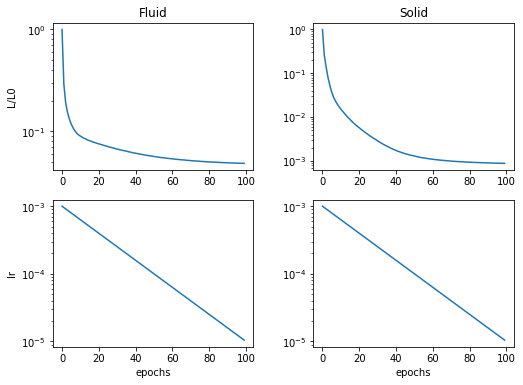

In [ ]:
#-----loss outputs----------
loss_fluid = H_fluid.history["loss"]
loss_solid = H_solid.history["loss"]

def cust_semilogx(AX, X, Y, xlabel, ylabel, title):
    if X is None:
        im = AX.semilogy(Y)
    else:
        im = AX.semilogy(X, Y)
    if xlabel is not None: AX.set_xlabel(xlabel)
    if ylabel is not None: AX.set_ylabel(ylabel)
    if title  is not None: AX.set_title(title)  

fig, ax = plt.subplots(2, 2, figsize=(8,6))
cust_semilogx(ax[0,0], None, np.array(loss_fluid)/loss_fluid[0], None, "L/L0", "Fluid")
cust_semilogx(ax[0,1], None, np.array(loss_solid)/loss_solid[0], None, None, "Solid")
cust_semilogx(ax[1,0], None, np.array(H_solid.history["lr"]), "epochs", "lr", None)
cust_semilogx(ax[1,1], None, np.array(H_solid.history["lr"]), "epochs", None, None)
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.2)
plt.show()

In [ ]:
#---grids for evaluation and exact solution--------
log10p = lambda x: np.log10(1. + x)
Nx, Ny, Nt = 5, 100, 200
ys = np.linspace(yd_min, yd_max, Ny*3)
ts = (np.logspace(0., log10p(td_f*t_star), Nt*3)-1.0)/t_star

Ydtest, Tdtest = np.meshgrid(ys, ts, indexing='ij')
input_test = [Ydtest, Tdtest] 

Ytest = Ydtest*x_star
Ttest = Tdtest*t_star

ys_line_plot = np.linspace(yd_min, yd_max, Ny*3)
ts_line_plot = [td_f*0.01, td_f*0.025, td_f*0.05,td_f*0.1, td_f*0.25, td_f*0.5, td_f*0.75, td_f*1.0]   
input_test_line_plot = np.meshgrid(ys_line_plot, ts_line_plot, indexing='ij')


In [ ]:
#----Exact pressure for contour and line plot----
p_true_contour = np.zeros_like(input_test[0])  
for i in range(100):
    Ci = 4*(-1)**i / (np.pi*(2*i+1))
    Lisq = np.pi*(2*i+1)/2
    Zz = np.cos(Lisq * input_test[0])
    Tt = np.exp(-Lisq**2 * input_test[1])
    p_true_contour += Ci * Zz * Tt
    

p_true_line = np.zeros_like(input_test_line_plot[0])  
for i in range(100):
    Ci = 4*(-1)**i / (np.pi*(2*i+1))
    Lisq = np.pi*(2*i+1)/2
    Zz = np.cos(Lisq * input_test_line_plot[0])
    Tt = np.exp(-Lisq**2 * input_test_line_plot[1])
    p_true_line += Ci * Zz * Tt   
    

#-----Exact displacement for contour and line plot----
F2 = np.zeros_like(input_test[0])
for i in range(100):
    Ci = 8 / ((np.pi*(2*i+1))**2)
    Lisq = np.pi*(2*i+1)/2
    Zz = np.cos(Lisq * (1 - input_test[0]))
    Tt = 1 - np.exp(-(Lisq**2) * input_test[1])
    F2 += Ci * Zz * Tt  
    
term1 = S_overburden*Ly*(1-2*nu_u)*(input_test[0])/(2*Gshr*(1-nu_u))
term2 = S_overburden*Ly*(nu_u-nu)/(2*Gshr*(1-nu_u)*(1-nu))
v_true_contour = term1 + term2*F2 


F2 = np.zeros_like(input_test_line_plot[0])
for i in range(100):
    Ci = 8 / ((np.pi*(2*i+1))**2)
    Lisq = np.pi*(2*i+1)/2
    Zz = np.cos(Lisq * (1 - input_test_line_plot[0]))
    Tt = 1 - np.exp(-(Lisq**2) * input_test_line_plot[1])
    F2 += Ci * Zz * Tt  

term1 = S_overburden*Ly*(1-2*nu_u)*(input_test_line_plot[0])/(2*Gshr*(1-nu_u))
term2 = S_overburden*Ly*(nu_u-nu)/(2*Gshr*(1-nu_u)*(1-nu))
v_true_line = term1 + term2*F2 

In [ ]:
#------------predicted values--------
pred = {
    'v': (vd.eval(model_pred, input_test))*u_star/m,
    'v_line': (vd.eval(model_pred, input_test_line_plot))*u_star/m,
    'v_true_contour': v_true_contour, 
    'v_true_line': v_true_line,
    'p': (pd.eval(model_pred, input_test))*p_star/MPa,
    'p_line': (pd.eval(model_pred, input_test_line_plot))*p_star/MPa,
    'p_true_contour': p_true_contour *(p_star/MPa),
    'p_true_line': p_true_line *(p_star/MPa),
}
#-------plot settings------
legend_settings = {
    'bbox_to_anchor': (1.25, 0.25),
    'loc': 'upper left',
    'fontsize': 'medium',
    'fancybox': True,
    'frameon': False}

subplot_adust = [0.1, 0.15, 0.85, 0.85, 0.45, 0.35]
line_color = ['red','orange', 'blue', 'green', 'purple','cyan','gold', 'black']

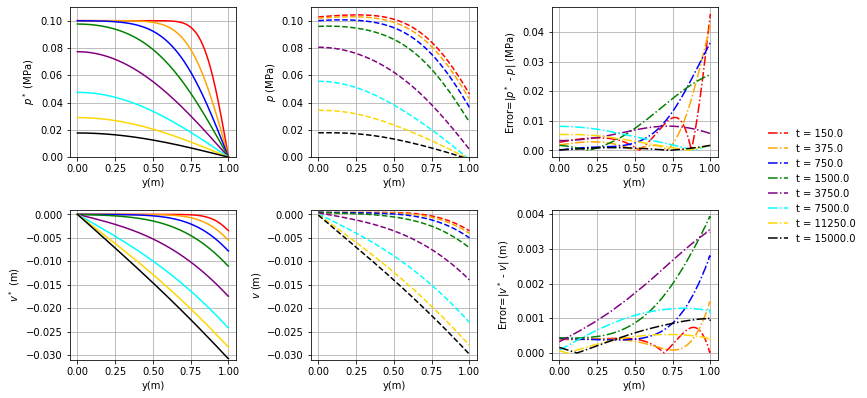

In [ ]:
#--------------comparison of the PINN and exact solution in the line plot-----------
fig, ax = plt.subplots(2,3, figsize=(12,7))

for i in range(np.size(ts_line_plot)):
    time_plot=np.around(ts_line_plot[i]*t_star,decimals=2)
    ax[0,0].plot(ys_line_plot, pred['p_true_line'][:,i], color=line_color[i],linestyle='-',label='t = '+str(time_plot))
    ax[0,1].plot(ys_line_plot, pred['p_line'][:,i], color=line_color[i], linestyle='--', label='t = '+str(time_plot))
    ax[0,2].plot(ys_line_plot,np.abs(pred['p_line'][:,i]-pred['p_true_line'][:,i]),
               color=line_color[i],linestyle='-.',label='t = '+str(time_plot))
    ax[1,0].plot(ys_line_plot, pred['v_true_line'][:,i], color=line_color[i],linestyle='-')
    ax[1,1].plot(ys_line_plot, pred['v_line'][:,i], color=line_color[i], linestyle='--')
    ax[1,2].plot(ys_line_plot,np.abs(pred['v_line'][:,i]-pred['v_true_line'][:,i]),
               color=line_color[i],linestyle='-.',label='t = '+str(time_plot))
    
ax[0,0].set_xlabel('y(m)'),ax[0,0].set_ylabel('$p^*$ (MPa)')
ax[0,1].set_xlabel('y(m)'),ax[0,1].set_ylabel('$p$ (MPa)')
ax[0,2].set_xlabel('y(m)'),ax[0,2].set_ylabel('Error=|$p^*$ - $p$| (MPa)')
ax[0,0].set_ylim(0.0,0.11), ax[0,1].set_ylim(0.0,0.11)
ax[1,0].set_xlabel('y(m)'),ax[1,0].set_ylabel('$v^*$ (m)')
ax[1,1].set_xlabel('y(m)'),ax[1,1].set_ylabel('$v$ (m)')
ax[1,2].set_xlabel('y(m)'),ax[1,2].set_ylabel('Error=|$v^*$ - $v$| (m)')
ax[1,0].set_ylim(-0.031,0.001), ax[1,1].set_ylim(-0.031,0.001)
ax[0,2].legend(**legend_settings),ax[0,0].grid(True),ax[0,1].grid(True),ax[0,2].grid(True)
ax[1,0].grid(True),ax[1,1].grid(True),ax[1,2].grid(True)
plt.subplots_adjust(*subplot_adust)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


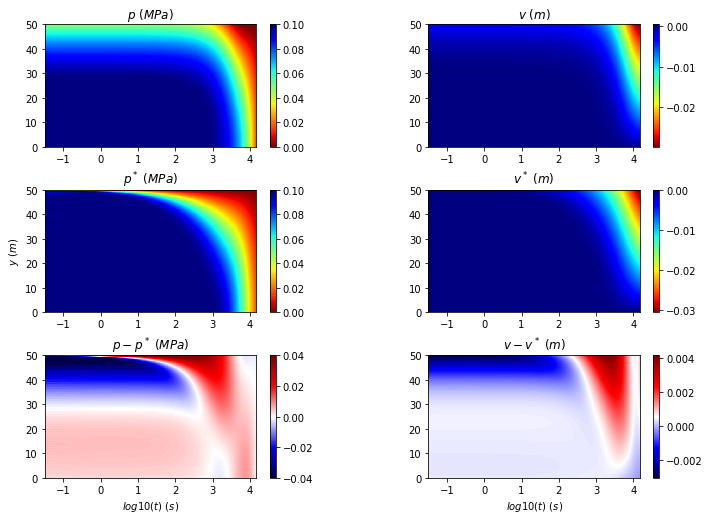

In [ ]:
#----------contour plots of pressure and displacement-------
y_plot = input_test[0]*x_star
t_plot = np.log10(input_test[1]*t_star)

fig, ax = plt.subplots(3,2,figsize=(12, 9))

plt.colorbar(ax[0,0].pcolor(t_plot, y_plot, pred['p'], cmap='jet_r', vmin=0, vmax=0.1), ax=ax[0,0])
plt.colorbar(ax[1,0].pcolor(t_plot, y_plot, pred['p_true_contour'], cmap='jet_r', vmin=0, vmax=0.1), ax=ax[1,0])
plt.colorbar(ax[2,0].pcolor(t_plot, y_plot, (pred['p'] - pred['p_true_contour']),cmap='seismic',
                           vmin=-0.04, vmax=0.04), ax=ax[2,0])

ax[0,0].set_title('$p~(MPa)$')
ax[1,0].set_title('$p^*~(MPa)$')
ax[1,0].set_ylabel('$y~(m)$')
ax[2,0].set_title('$p-p^*~(MPa)$')
ax[2,0].set_xlabel('$log10(t)~(s)$')

plt.colorbar(ax[0,1].pcolor(t_plot, y_plot, pred['v'], cmap='jet_r'), ax=ax[0,1])
plt.colorbar(ax[1,1].pcolor(t_plot, y_plot, pred['v_true_contour'], cmap='jet_r'), ax=ax[1,1])
plt.colorbar(ax[2,1].pcolor(t_plot, y_plot, (pred['v'] - pred['v_true_contour']),cmap='seismic'), ax=ax[2,1])

ax[0,1].set_title('$v~(m)$')
ax[1,1].set_title('$v^*~(m)$')
ax[2,1].set_title('$v-v^*~(m)$')
ax[2,1].set_xlabel('$log10(t)~(s)$')
for i in range(3):
    ax[i,0].set_ylim(np.min(y_plot),np.max(y_plot)), ax[i,1].set_ylim(np.min(y_plot),np.max(y_plot))
    ax[i,0].set_xlim(-1.5,np.max(t_plot)), ax[i,1].set_xlim(-1.5,np.max(t_plot))
plt.subplots_adjust(*subplot_adust)
plt.show()
